In [1]:
# These are some basic packages
import random, re, math, os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# These are for data processing
import tensorflow_addons as tfa
from kaggle_datasets import KaggleDatasets


# These are for model training
from tensorflow.keras.mixed_precision import experimental as mixed_precision
from tensorflow.keras.applications import DenseNet201
import tensorflow.keras.backend as K


# These are performance metricsb
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix


# These are for class weights
import datetime
import tqdm
import json
from collections import Counter
from  sklearn.utils.class_weight import compute_class_weight
#import gc

2022-07-18 19:52:00.569228: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-07-18 19:52:00.569363: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Detect the hardware and tell the appropriate distribution strategy

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

# Make the system tune the number of threads for us
AUTO = tf.data.experimental.AUTOTUNE

Running on TPU  grpc://10.0.0.2:8470


2022-07-18 19:52:07.048781: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-18 19:52:07.051320: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-07-18 19:52:07.051349: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-18 19:52:07.051377: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c5e585f13fcb): /proc/driver/nvidia/version does not exist
2022-07-18 19:52:07.053784: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

REPLICAS:  8


### Configuration for image size, training epoch, batch size, and random seed

In [3]:
IMAGE_SIZE = [512, 512]
EPOCHS = 100
SEED = 100
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
tf.random.set_seed(SEED)
ENABLE_DATA_AUG = True

### Set the data access

In [4]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')
# These are available image sizes in the data set
GCS_PATH_SELECT = { 
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec')

2022-07-18 19:52:13.933139: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-07-18 19:52:14.022147: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-07-18 19:52:14.090841: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [5]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)  # Number of images in training set
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)  # Number of images in validation set
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)  # Number of images in test set
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE  # Steps of each epoch
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


### Add more mixed precision and/or XLA (refer to Chris Deotte's notebook)

In [6]:
# Add more mixed precision and/or XLA to allow the TPU memory to handle larger batch sizes 
# and can speed up the training process
MIXED_PRECISION = True
XLA_ACCELERATE = True

# mixed precision and data aug are not compatible
if MIXED_PRECISION :
    if tpu: policy = tf.keras.mixed_precision.experimental.Policy('mixed_bfloat16')
    else: policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    mixed_precision.set_policy(policy)
    print('Mixed precision enabled')
    
if XLA_ACCELERATE:
    tf.config.optimizer.set_jit(True)
    print('Accelerated Linear Algebra enabled')

Mixed precision enabled
Accelerated Linear Algebra enabled


### Show all the classes we have

In [7]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose'] 


## Step 2: Set some visualization functions

### Set training and validation curve function to show the changes in loss and accuracy

In [8]:
def plot_train_valid_curves(training, validation, title, subplot):
    
    if subplot % 10 == 1:
        plt.subplots(figsize = (15,15), facecolor = '#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['training', 'validation.'])

### Set a function to plot confusion matrix

In [9]:
def display_confusion_matrix(cmat, score, precision, recall):
    
    plt.figure(figsize = (20,20))  # Specify the size of confusion matrix
    ax = plt.gca()
    ax.matshow(cmat, cmap = 'Reds')  # Draw a matrix
    ax.set_xticks(range(len(CLASSES)))  # Set the range of X coordinate according to #classes
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})  # Set the font size of X coordinate
    # Rotate labels on X coordinate to make them look better
    plt.setp(ax.get_xticklabels(), rotation = 45, ha = "left", rotation_mode = "anchor")
    ax.set_yticks(range(len(CLASSES)))  # Set the range of Y coordinate according to #classes
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})  # Set the font size of Y coordinate
    # Rotate labels on Y coordinate to make them look better
    plt.setp(ax.get_yticklabels(), rotation = 45, ha = "right", rotation_mode = "anchor")
    # Round F1 score, precision, and recall to the nearest fourth decimal place
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.4f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.4f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.4f} '.format(recall)
    # Add some comments about F1 score, precision, and recall on the plot
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict = {'fontsize': 18, 'horizontalalignment': 'right', 'verticalalignment': 'top', 'color': 'Blue'})
    plt.show()

### Show the beautiful flowers (refer to Dimitre Oliveira)

In [10]:
def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object:
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (for test data)
    return numpy_images, numpy_labels


def title_from_label_and_target_(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct


def display_one_flower(image, title, subplot, red = False, titlesize = 16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize = int(titlesize) if not red else int(titlesize / 1.2), color = 'red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2] + 1)


def display_batch_of_images(databatch, predictions = None):
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
    rows = int(math.sqrt(len(images)))
    cols = len(images) // rows
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot = (rows,cols,1)
    if rows < cols:
        plt.figure(figsize = (FIGSIZE, FIGSIZE / cols*rows))
    else:
        plt.figure(figsize = (FIGSIZE / rows * cols,FIGSIZE))
    
    # Display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target_(predictions[i], label)
        dynamic_titlesize = FIGSIZE * SPACING / max(rows,cols) * 40 + 3
        subplot = display_one_flower(image, title, subplot, not correct, titlesize = dynamic_titlesize)
    
    # Layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace = 0, hspace = 0)
    else:
        plt.subplots_adjust(wspace = SPACING, hspace = SPACING)
    plt.show()
    

# Visualize model predictions (on training and validation sets)
# Images of flowers with labels telling whether prediction is true will be shown
def dataset_to_numpy_util(dataset, N):
    dataset = dataset.unbatch().batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;  
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    label = np.argmax(label, axis = -1)
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', should be ' if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower_eval(image, title, subplot, red = False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize = 14, color = 'red' if red else 'black')
    return subplot + 1

def display_9_images_with_predictions(images, predictions, labels):
    subplot = 331
    plt.figure(figsize = (13,13))
    for i, image in enumerate(images):
        title, correct = title_from_label_and_target(predictions[i], labels[i])
        subplot = display_one_flower_eval(image, title, subplot, not correct)
        if i >= 8:
            break;
    plt.tight_layout()
    plt.subplots_adjust(wspace = 0.1, hspace = 0.1)
    plt.show()

## Step 3: Set functions to gain training set, validation set, and test set

### Decode images and convert pixels to floats between 0 and 1

In [11]:
def decode_image(image_data):
    
    image = tf.image.decode_jpeg(image_data, channels = 3)
    image = tf.cast(image, tf.float32) / 255.0
    # Reshape the images to fit the size required by TPU
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    
    return image

### Set a function to read labeled tfrec files (i.e. training & validation set) and unlabeled tfrec files (i.e. test set)

In [12]:
def read_labeled_tfrecord(example):
    
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    
    return image, label


# This is for data visualization
def read_labeled_id_tfrecord(example):
    
    LABELED_ID_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64),
        "id": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, LABELED_ID_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    idnum =  example['id']
    
    return image, label, idnum

def read_unlabeled_tfrecord(example):
    
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "id": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    
    return image, idnum

### Load image data

In [13]:
# For best performance, read from multiple tfrec files at once
# Disregard data's order, since data will be shuffled
def load_dataset(filenames, labeled = True, with_id = False,ordered = False):
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False  # Disable order to increase running speed
    # Automatically interleaves reading
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
    # Use data in the shuffled order
    dataset = dataset.with_options(ignore_order)
    
    # Returns a dataset of (image, label) pairs if labeled = True (i.e. training & validation set)
    # or (image, id) pair if labeld = False (i.e. test set)
    if labeled == True:
        tfrecord_reader = read_labeled_tfrecord
        if with_id == True:
            tfrecord_reader = read_labeled_id_tfrecord
    else:
        tfrecord_reader = read_unlabeled_tfrecord
    
    dataset = dataset.map(tfrecord_reader, num_parallel_calls=AUTO)
    
    return dataset

### Data augmentation

In [14]:
# Randomly make some changes to the images and return the new images and labels
def data_augment(image, label,*args):
        
    # Set seed for data augmentation
    seed = SEED
    
    # Randomly resize and then crop images
    #image = tf.image.resize(image, [720, 720])   # BBO
    #image = tf.image.random_crop(image, [512, 512, 3], seed = seed)

    # Randomly reset brightness of images
    image = tf.image.random_brightness(image, 0.6, seed = seed)
    
    # Randomly reset saturation of images
    image = tf.image.random_saturation(image, 3, 5, seed = seed)
        
    # Randomly reset contrast of images
    image = tf.image.random_contrast(image, 0.3, 0.5, seed = seed)

    # Randomly reset hue of images, but this will make the colors really weird, which we think will not happen
    # in common photography
    image = tf.image.random_hue(image, 0.5, seed = seed)
    
    # Blur images : BBO No deterministic operation in data augmentation
    #image = tfa.image.mean_filter2d(image, filter_shape = 10)
    
    # Randomly flip images
    image = tf.image.random_flip_left_right(image, seed = seed)
    image = tf.image.random_flip_up_down(image, seed = seed)
    
    # Fail to rotate and transform images due to some bug in TensorFlow
    #angle = random.randint(0, 180)
    #image = tfa.image.rotate(image, tf.constant(np.pi * angle / 180))
    
    # image = tfa.image.transform(image, [1.0, 1.0, -250, 0.0, 1.0, 0.0, 0.0, 0.0])
    
    return image, label

# additional data augmentation
# as of tf.__version__ == 2.4.1 Random* layers are experimental
data_augment_layers = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.2,fill_mode='nearest', dtype="float32"),
  tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.2,width_factor=0.2,fill_mode='nearest',dtype="float32"),
  tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2,width_factor=0.2,fill_mode='nearest',dtype="float32")
])

#def dump(*args):
#    print(f"nb args: {len(args)}")
#    for arg in args:
#        print(f"{type(arg)}: {arg}")
#    return args

ds_map_func = lambda func: lambda ds: ds.map(func,num_parallel_calls=AUTO) 

def apply_data_augment(ds,batched=True):
    if random.choice([True,False]):
        ds = ds_map_func(data_augment)(ds)
        if batched == True:
            ds = ds_map_func(lambda x, y:( tf.squeeze(data_augment_layers(tf.expand_dims(x, axis=0) ), axis=0), y ) )(ds)
        else:
            ds = ds_map_func(lambda x, y:(data_augment_layers(x), y) )(ds)
    return ds

### Gain training/validation/test datasets

In [15]:
#ds_map_func = lambda func: lambda ds: ds.map(func,num_parallel_calls=AUTO) 
#
#def apply_data_augment(ds):
#    ds = ds_map_func(data_augment)(ds)
#    #ds = ds_map_func(lambda x, y:( tf.squeeze(data_augment_layers(tf.expand_dims(x, axis=0) ), axis=0), y ) )(ds)
#    return ds
#
#def get_training_dataset(augment=True,preview=False):
#    train = load_dataset(TRAINING_FILENAMES, labeled = True)
#    #train = train.map(lambda image, label, idnum: [image, label])
#    
#    if augment == True:
#        train = apply_data_augment(train)
#    
#    if preview == False:
#        train = train.repeat()
#        train = train.shuffle(2048)
#        train = train.batch(BATCH_SIZE)
#        train = train.prefetch(AUTO)
#    else:
#        train = train.batch(BATCH_SIZE)
#        #train = train.cache()
#        train = train.prefetch(AUTO)
#    return train
#
#
#def get_validation_dataset(preview =False,ordered = False):
#    validation = load_dataset(VALIDATION_FILENAMES, labeled = True, ordered = ordered)
#    #validation = validation.map(lambda image, label, idnum: [image, label])
#    validation = validation.batch(BATCH_SIZE)
#    if preview == False:
#        validation = validation.cache()
#    # Prefetch next batch while training (autotune prefetch buffer size)
#    validation = validation.prefetch(AUTO)
#    return validation
#
#def get_test_dataset(ordered = False):
#    test = load_dataset(TEST_FILENAMES, labeled = False, ordered = ordered)
#    test = test.batch(BATCH_SIZE)
#    test = test.prefetch(AUTO)
#    return test
#
#
#get_one_batch = lambda ds,n=20: next(iter(ds.unbatch().batch(n)))

In [16]:
# possible kwargs: labeled,ordered,with_id
def get_training_dataset(**kwargs):
    train = load_dataset(TRAINING_FILENAMES, **{**kwargs,'labeled':True} )
    return train

def get_validation_dataset(**kwargs):
    validation = load_dataset(VALIDATION_FILENAMES, **{**kwargs,'labeled':True } )
    return validation

def get_test_dataset(**kwargs):
    test = load_dataset(TEST_FILENAMES,  **{**kwargs,'labeled':False })
    return test
    
def prepare_train(train):
    train = train.repeat()
    if ENABLE_DATA_AUG:
        train = apply_data_augment(train)
    train = train.shuffle(2048)
    train = train.batch(BATCH_SIZE)
    train = train.prefetch(AUTO)
    return train

def repeat_batch_prefetch(ds,count=1):
    #ds = ds.unbatch()
    ds = ds.repeat(count)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(AUTO)
    return ds

#
n_preview = 20
get_one_sample = lambda ds,n=n_preview: ds.batch(n).take(count=1).repeat()
re_batch       = lambda ds,n=n_preview: ds.unbatch().batch(n)
get_one_batch = lambda ds: next(iter(ds))

remove_id = lambda ds: ds.map(lambda image, label, idnum: [image, label])

In [17]:
train_ds = get_training_dataset()
val_ds   = get_validation_dataset()
test_ds  = get_test_dataset(ordered=True)
train_sample = get_one_sample(train_ds)
val_sample   = get_one_sample(val_ds)
test_sample  = get_one_sample(test_ds)

### Count the number of images

### Show the beautiful flowers in training set before with data augmentation

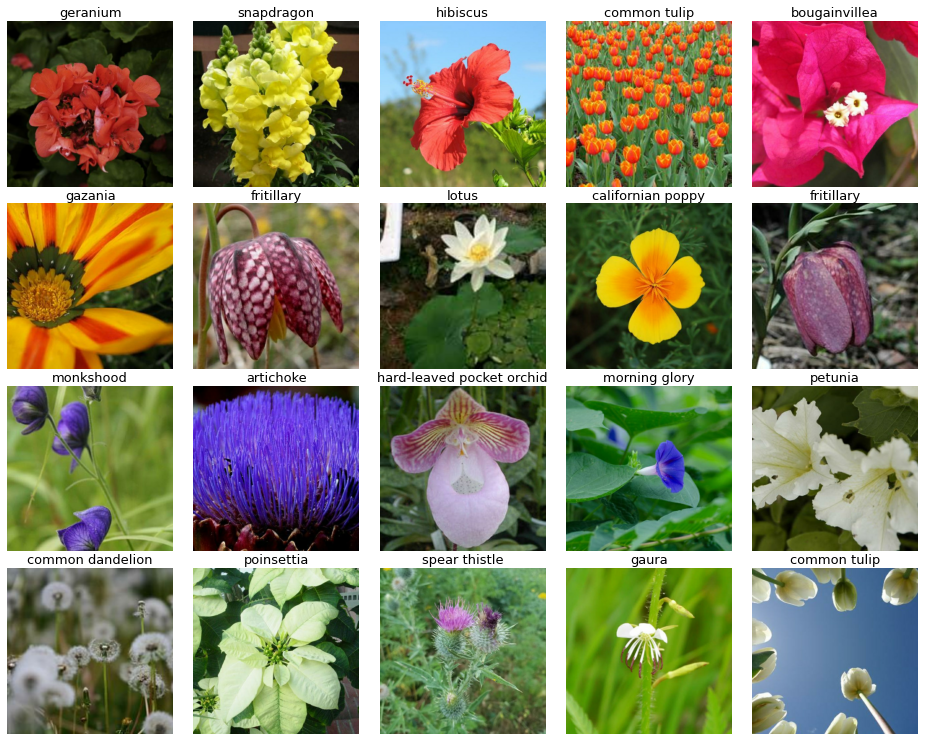

In [18]:
display_batch_of_images(get_one_batch(train_sample))

### Show the beautiful flowers in validation set (wo data augmentation)

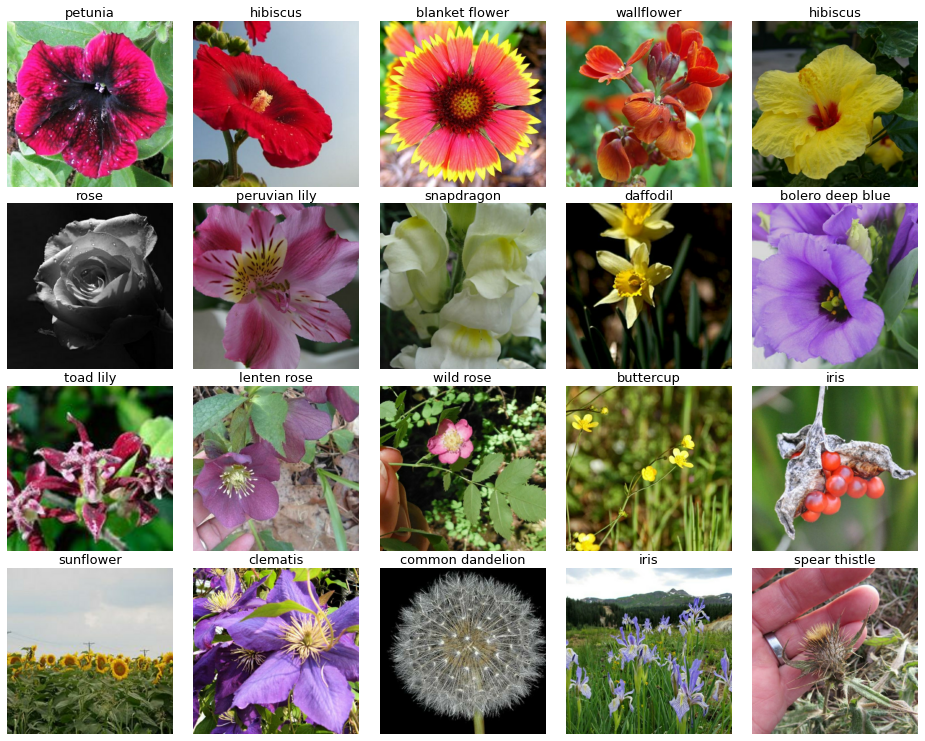

In [19]:
display_batch_of_images(get_one_batch(val_sample))

### Show the beautiful flowers in test set (wo data augmentation)

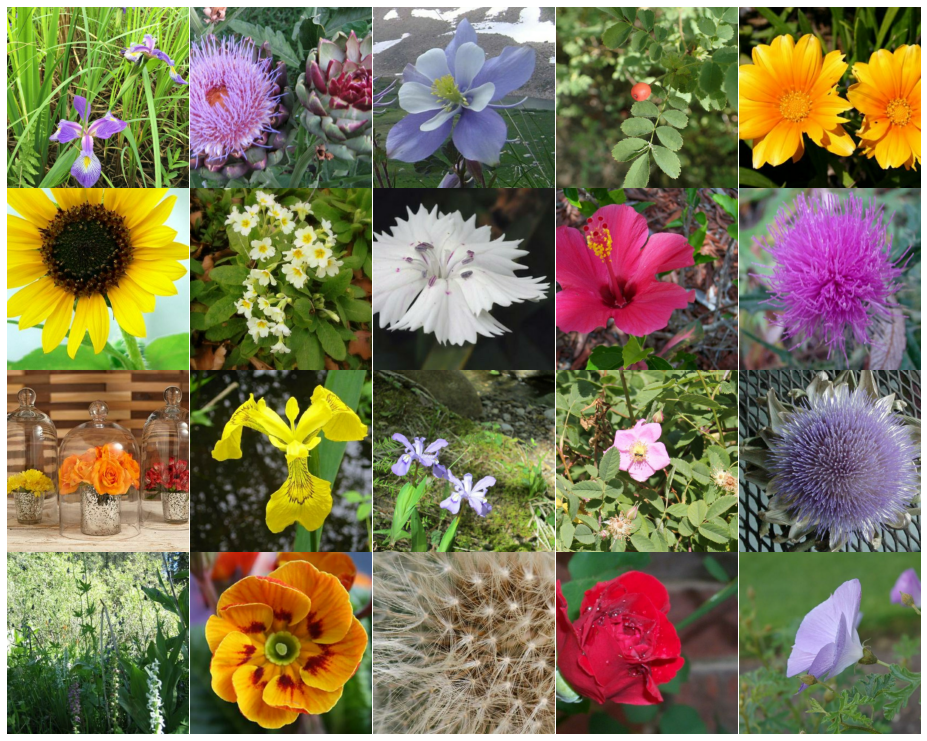

In [20]:
display_batch_of_images(get_one_batch(test_sample))

### Show example augmentation

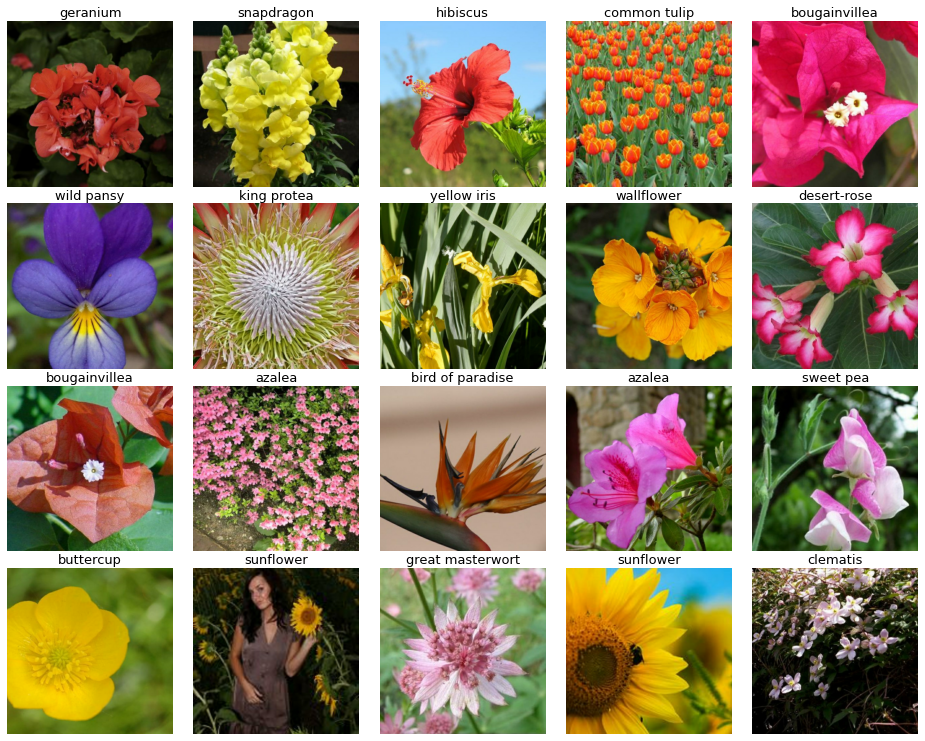

In [21]:
#row = 3
#col = 4
#all_elements = get_training_dataset().unbatch()
#one_element = tf.data.Dataset.from_tensors(next(iter(all_elements)))
# Map the images to the data augmentation function for image processing
#augmented_element = one_element.repeat().map(data_augment).batch(row * col)

#for (img, label) in augmented_element:
#    plt.figure(figsize = (15, int(15 * row / col)))
#    for j in range(row * col):
#        plt.subplot(row, col, j + 1)
#        plt.axis('off')
#        plt.imshow(img[j, ])
#    plt.show()
#    break

if ENABLE_DATA_AUG:
    display_batch_of_images(get_one_batch(apply_data_augment(re_batch(train_sample),batched=False)))

## Step 4: Build the model and make prediction

### Customize learning rate scheduler and visualize it

Learning rate schedule: 1e-05 to 0.0004 to 1e-05


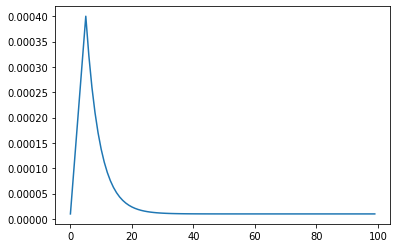

In [22]:
def lrfn(epoch):
    
    LR_START = 0.00001
    LR_MAX = 0.00005 * strategy.num_replicas_in_sync
    LR_MIN = 0.00001
    LR_RAMPUP_EPOCHS = 5
    LR_SUSTAIN_EPOCHS = 0
    LR_EXP_DECAY = .8
    
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY ** (epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

# Visualization changes in learning rate
rng = [i for i in range(25 if EPOCHS<25 else EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

### Build the model and load it into TPU

In [23]:
with strategy.scope():
    # Create DenseNet201 model
    rnet = DenseNet201(
        input_shape = (512, 512, 3),
        weights = 'imagenet',  # Use the preset parameters of ImageNet
        include_top = False  # Drop the fully connected network on the top
    )
    
    rnet.trainable = True
    model = tf.keras.Sequential([
        rnet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation = 'softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),  # Use Adam Algorithm for optimization
        # For multiclassification, we can use cross entropy or sparse cross entropy as our loss function 
        # These two cross entropy are the same in essence, but they are applied in different scenarios
        # If our target is one-hot encoded, it is better to use cross entropy
        # If our target is an integer, sparse cross entropy is a better choice, and this is our case
        loss = 'sparse_categorical_crossentropy', 
        metrics = ['sparse_categorical_accuracy']
    )

    model.summary()
    # Save the model BBO
    #model.save('ML_finalproject.h5')

74842112/74836368 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 16, 16, 1920)      18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 104)               199784    
Total params: 18,521,768
Trainable params: 18,292,712
Non-trainable params: 229,056
_________________________________________________________________


### Calculate weight for each class (refer to Roman Weilguny)

In [24]:
#gc.enable()
#
#def get_training_dataset_raw():
#    dataset = load_dataset(TRAINING_FILENAMES, labeled = True, with_id = True, ordered = False)
#    return dataset
#
#raw_training_dataset = get_training_dataset_raw()
#
#label_counter = Counter()
#all_labels = []
#for images, labels, id in raw_training_dataset:
#    l = labels.numpy()
#    label_counter.update([l])
#    all_labels.append(l)
#
#del raw_training_dataset    
##del all_labels
#
##def get_weight_for_class(class_id):
##    TARGET_NUM_PER_CLASS = 122
##    counting = label_counter[class_id]
##    weight = TARGET_NUM_PER_CLASS / counting
##    return weight
#
##weight_per_class = {class_id: get_weight_for_class(class_id) for class_id in range(len(CLASSES))}
#
## use sklearn dedicated function to compute class weights
#all_labels = np.array(all_labels)
#sk_weights = compute_class_weight('balanced',classes=np.unique(all_labels),y=all_labels)
#weight_per_class = {i:w for (i,w) in enumerate(sk_weights) }
##del all_labels

In [25]:
label_counter = Counter()
all_labels = []
for images, labels in train_ds.repeat(count=1):
    l = labels.numpy()
    label_counter.update([l])
    all_labels.append(l)

#def get_weight_for_class(class_id):
#    TARGET_NUM_PER_CLASS = 122
#    counting = label_counter[class_id]
#    weight = TARGET_NUM_PER_CLASS / counting
#    return weight

#weight_per_class = {class_id: get_weight_for_class(class_id) for class_id in range(len(CLASSES))}

# use sklearn dedicated function to compute class weights
all_labels = np.array(all_labels)
sk_weights = compute_class_weight('balanced',classes=np.unique(all_labels),y=all_labels)
weight_per_class = {i:w for (i,w) in enumerate(sk_weights) }

2022-07-18 19:53:44.302841: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 82000, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1658174024.299555287","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 82000, Output num: 0","grpc_status":3}


samples per class     weights
count         104.000000  104.000000
mean          122.625000    2.375689
std           148.211158    1.971072
min            18.000000    0.156809
25%            32.500000    0.977138
50%            88.000000    1.393646
75%           125.500000    3.775843
max           782.000000    6.812500

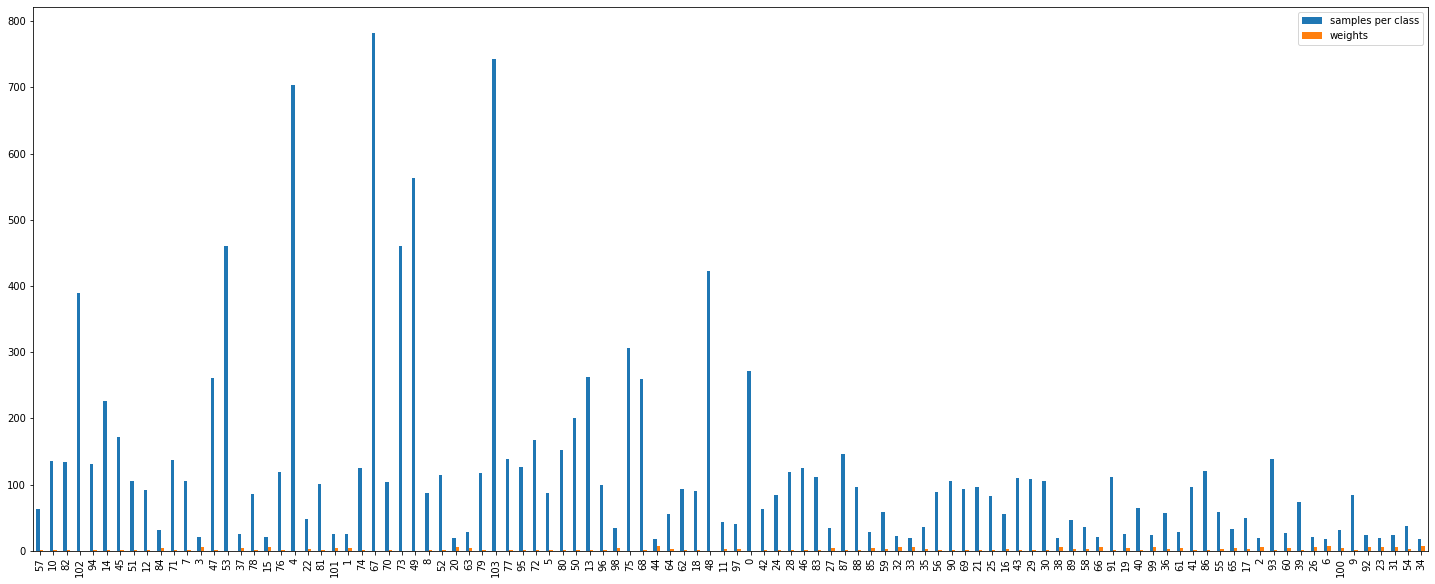

In [26]:
index = list(label_counter.keys())
counts = pd.DataFrame(data={'samples per class':label_counter.values(),'weights':[weight_per_class[i] for i in index]},index=index)
display(counts.describe())
fig,ax = plt.subplots(figsize=(25,10))
_ = counts.plot(kind='bar',ax=ax)

### Train the model

In [27]:
fit_patience=5
fit_min_delta=0.001
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='sparse_categorical_accuracy',mode='max',patience=fit_patience,min_delta=fit_min_delta,restore_best_weights=True,verbose=1)

history = model.fit(
    prepare_train(train_ds), #get_training_dataset(),
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = EPOCHS,
    callbacks = [lr_callback,early_stopping_cb],
    validation_data = repeat_batch_prefetch(val_ds),
    class_weight = weight_per_class
)

Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
99/99 [==============================] - 247s 858ms/step - loss: 4.8156 - sparse_categorical_accuracy: 0.0162 - val_loss: 4.5756 - val_sparse_categorical_accuracy: 0.0183


2022-07-18 19:57:55.874230: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 107267, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1658174275.873584508","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 107267, Output num: 0","grpc_status":3}


Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
99/99 [==============================] - 50s 508ms/step - loss: 4.0176 - sparse_categorical_accuracy: 0.1164 - val_loss: 3.0742 - val_sparse_categorical_accuracy: 0.2462
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
99/99 [==============================] - 54s 550ms/step - loss: 2.2697 - sparse_categorical_accuracy: 0.4491 - val_loss: 1.7416 - val_sparse_categorical_accuracy: 0.5506
Epoch 4/100

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
99/99 [==============================] - 55s 559ms/step - loss: 1.4975 - sparse_categorical_accuracy: 0.6223 - val_loss: 1.6106 - val_sparse_categorical_accuracy: 0.5948
Epoch 5/100

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000322.
99/99 [==============================] - 58s 587ms/step - loss: 1.1104 - sparse_categorical_accuracy: 0.6964 - val_loss: 2.1336 - val_sparse_categorical_ac

### Show how loss and accuracy changes on training set

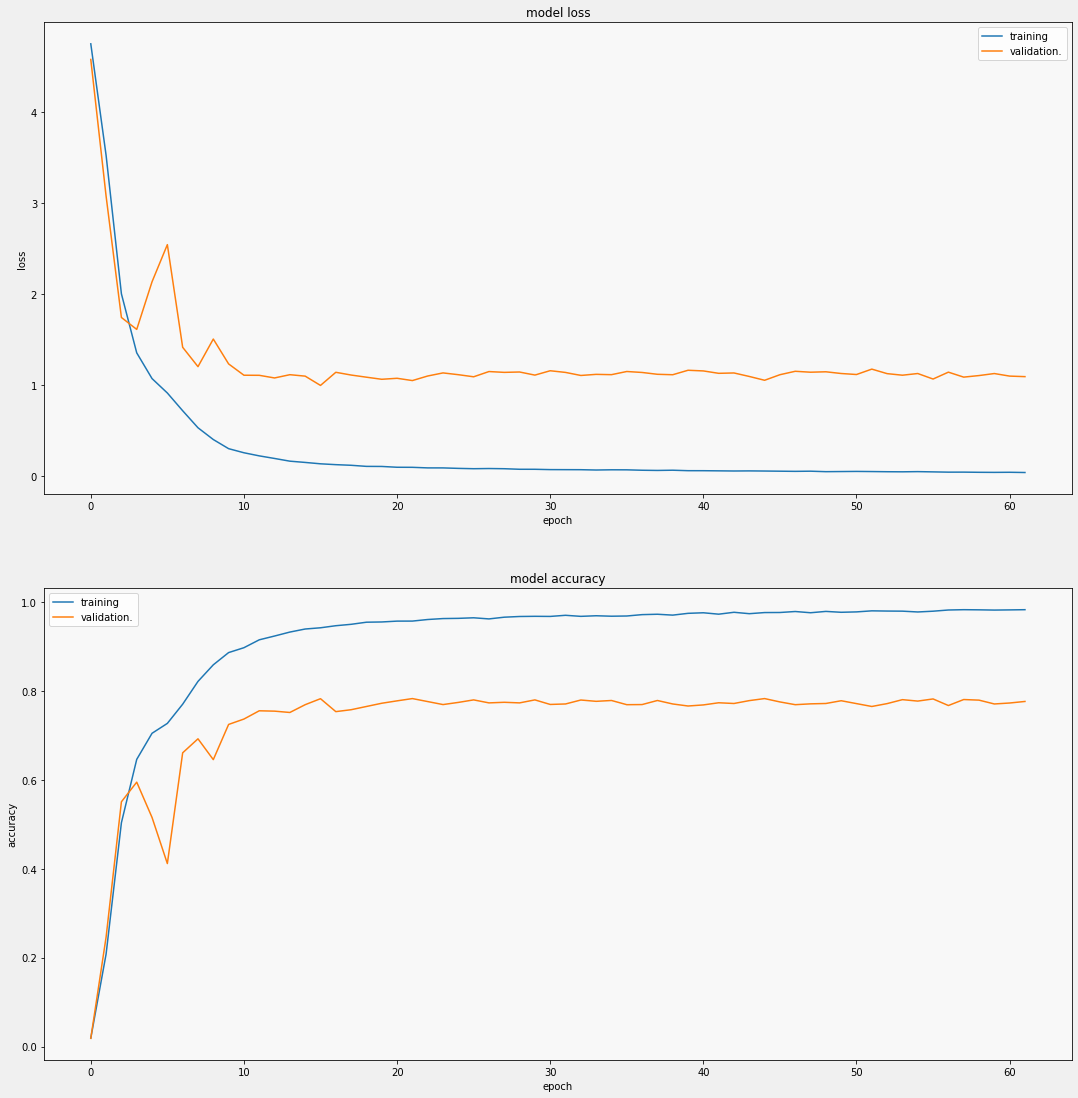

In [28]:
plot_train_valid_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)  # Loss curve
plot_train_valid_curves(history.history['sparse_categorical_accuracy'], 
                        history.history['val_sparse_categorical_accuracy'], 'accuracy', 212)  # Accuracy curve

### Check model's performance on validation set

In [29]:
#cmdataset = get_validation_dataset(ordered = True)

cmdataset =  repeat_batch_prefetch(val_ds)

images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch() 

cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()  # Get everything as one batch
cm_probabilities = model.predict(images_ds)  # The probability that each image is of each class
cm_predictions = np.argmax(cm_probabilities.astype(np.float32), axis = -1)  # The class of the largest probability is what we need

print("Correct labels: ", cm_correct_labels.shape, cm_correct_labels)
print("Predicted labels: ", cm_predictions.shape, cm_predictions)

Correct labels:  (3712,) [50 82 99 ... 71 67 48]
Predicted labels:  (3712,) [50 82  9 ... 71 48 13]


2022-07-18 20:57:16.784486: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 435964, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1658177836.783693821","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 435964, Output num: 0","grpc_status":3}


### Draw the confusion matrix, compute F1 score, precision, and recall

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


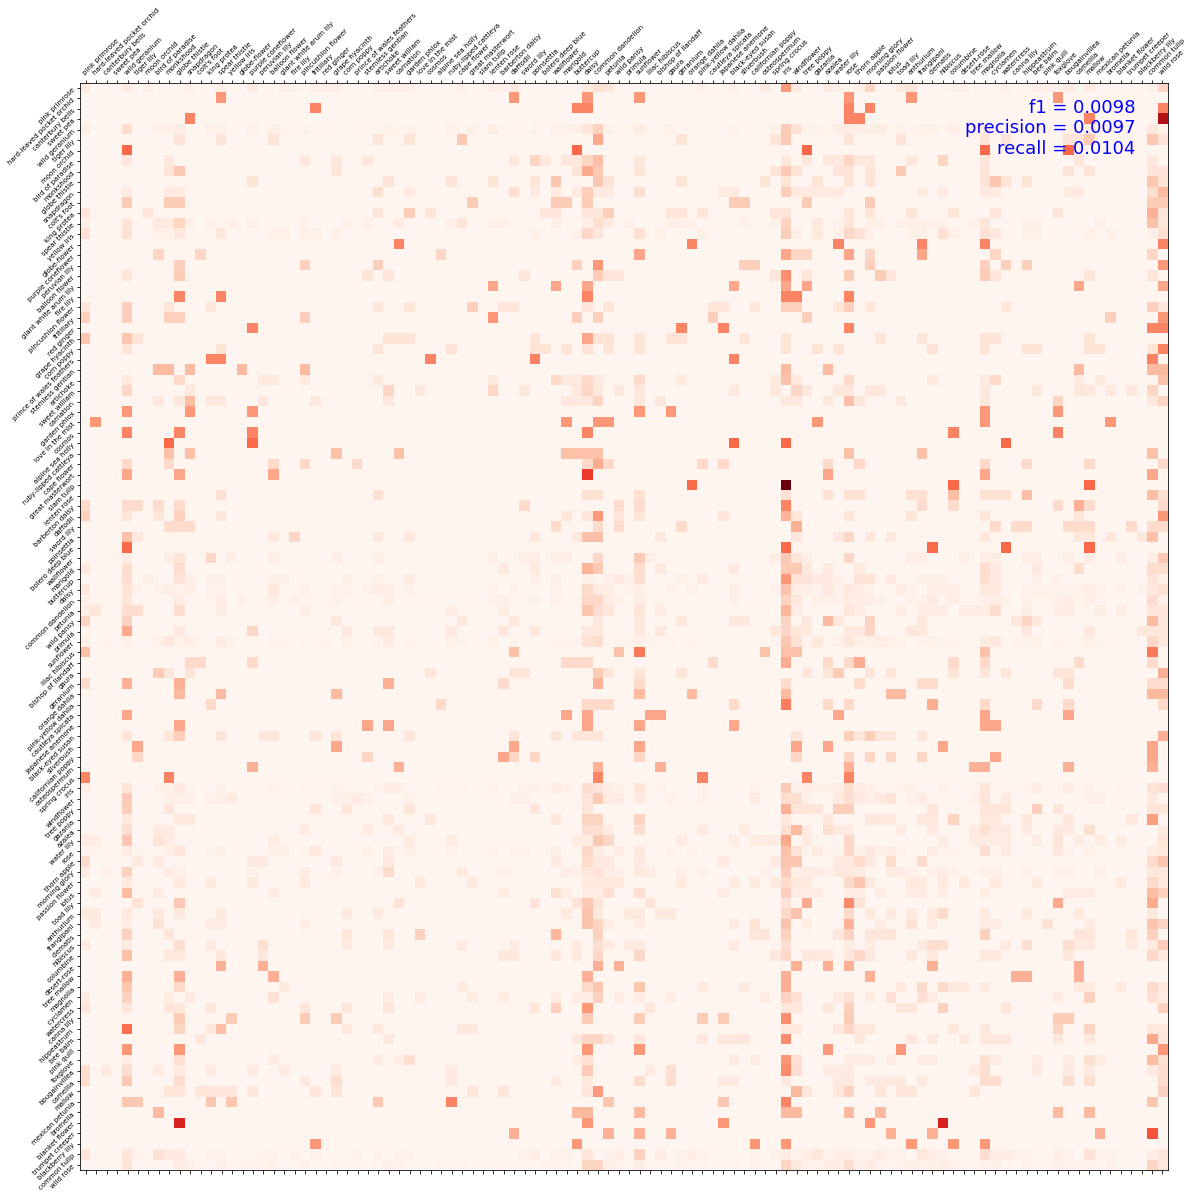

f1 score: 0.010, precision: 0.010, recall: 0.010


In [30]:
cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels = range(len(CLASSES)))
score = f1_score(cm_correct_labels, cm_predictions, labels = range(len(CLASSES)), average = 'macro')
precision = precision_score(cm_correct_labels, cm_predictions, labels = range(len(CLASSES)), average = 'macro')
recall = recall_score(cm_correct_labels, cm_predictions, labels = range(len(CLASSES)), average = 'macro')
cmat = (cmat.T / cmat.sum(axis = 1)).T
display_confusion_matrix(cmat, score, precision, recall)
print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

### Make prediction

In [31]:
def make_prediction(test_ds):
    test_images_ds = test_ds.map(lambda image, idnum: image)
    probabilities = model.predict(test_images_ds)  # Compute the probability that each image is of each class
    predictions = np.argmax(probabilities.astype(np.float32), axis = -1)  # Use the one with largest probability as the predicted class
    print(predictions)

    # Generate submission file, remember to name it by "submission.csv"
    test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
    test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')
    test = pd.DataFrame({"id": test_ids, "label": predictions})
    print(test.head)
    test.to_csv("submission.csv",index = False)
    
make_prediction(repeat_batch_prefetch(test_ds))

[ 67  28  83 ...  94 102  62]
<bound method NDFrame.head of              id  label
0     252d840db     67
1     1c4736dea     28
2     c37a6f3e9     83
3     00e4f514e    103
4     59d1b6146     70
...         ...    ...
7377  c785abe6f      7
7378  9b9c0e574     73
7379  e46998f4d     94
7380  523df966b    102
7381  e86e2a592     62

[7382 rows x 2 columns]>
